## Final Project : Image classification using CNN for Bags

| Course | Foundations of Machine Learning Frameworks |
|--------|--------------------------------------------|
| Professor | Ran Feldesh                             |
| Group  | Group 10                                   |
| Members | 8930180 - Burman, Jaiv Chaitanya <br>  9027375 - Lad, Khushbu Nileshkumar|        
| Due date | 11th, December, 2024                       |

### Introduction

This project aims to develop an image classification model using Convolutional Neural Networks (CNN) to classify bags into three distinct categories: plastic, paper, and garbage bags.
<br>
Using deep learning to precisely recognise and classify various bag kinds according to their visual attributes is the main objective. The model will learn to extract relevant characteristics from photos by being trained on a labelled dataset. 
<br>
This will allow for automatic categorization, which may be used to a variety of real-world scenarios, including recycling, trash management, and environmental sustainability initiatives. 
<br>
The potential of CNNs in picture identification tasks is investigated in this project, which also helps to improve material recycling and sorting efficiency.

### 1. Obtain data and initialization

1. Downloaded the dataset
2. Added .data folder in repository and added it into gitignore.
3. Extracted downloaded files into .data folder
4. Path to data is ".data\Waste-Classification\Bag Classes"
5. Compress and divide train data into train, validation and test set as per class notebook

#### Import Libraries

In [84]:
import os, shutil, pathlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from PIL import Image
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import image_dataset_from_directory
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve
import random
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, accuracy_score
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2

#### Directory variables

In [27]:
original_dir = pathlib.Path(".data/Waste-Classification/Bag Classes/")
new_base_dir = pathlib.Path(".data/Waste-Classification/Subsets/")
new_base_dir_train = pathlib.Path(".data/Waste-Classification/Subsets/train/")
new_base_dir_validation = pathlib.Path(".data/Waste-Classification/Subsets/validation/")
new_base_dir_test = pathlib.Path(".data/Waste-Classification/Subsets/test/")
labels = ["Garbage Bag Images","Paper Bag Images","Plastic Bag Images"]

#### Create Subsets

In [23]:
def make_subset(subset_name, start_index, end_index):
    for category in labels:
        from_dir = original_dir / category
        to_dir = new_base_dir / subset_name / category
        os.makedirs(to_dir)
        files = [f for f in os.listdir(from_dir) if os.path.isfile(os.path.join(from_dir, f))]
        for i, fname in enumerate(files):
            if start_index <= i < end_index:
                shutil.copyfile(src=from_dir / fname, dst=to_dir / fname)
                            

make_subset("train", start_index=0, end_index=2000)             # 2000
make_subset("validation", start_index=2000, end_index=3000)     # 1000
make_subset("test", start_index=3000, end_index=5000)           # 2000

### 2. EDA: Explore the data

#### Verify subsets

In [24]:
for subset in ["train", "validation", "test"]:
    for category in labels:
        dir_path = new_base_dir / subset / category
        print(f"{subset}/{category}: {len(os.listdir(dir_path))} images")

train/Garbage Bag Images: 2000 images
train/Paper Bag Images: 2000 images
train/Plastic Bag Images: 2000 images
validation/Garbage Bag Images: 1000 images
validation/Paper Bag Images: 1000 images
validation/Plastic Bag Images: 1000 images
test/Garbage Bag Images: 2000 images
test/Paper Bag Images: 2000 images
test/Plastic Bag Images: 2000 images


#### Show sample Images

.data\Waste-Classification\Subsets\train\Garbage Bag Images\Garbage Bag Images(2192).jpg
.data\Waste-Classification\Subsets\train\Garbage Bag Images\Garbage Bag Images(1163).jpg
.data\Waste-Classification\Subsets\train\Garbage Bag Images\Garbage Bag Images(2493).jpg
.data\Waste-Classification\Subsets\train\Garbage Bag Images\Garbage Bag Images(2275).jpg
.data\Waste-Classification\Subsets\train\Garbage Bag Images\Garbage Bag Images(1168).jpg


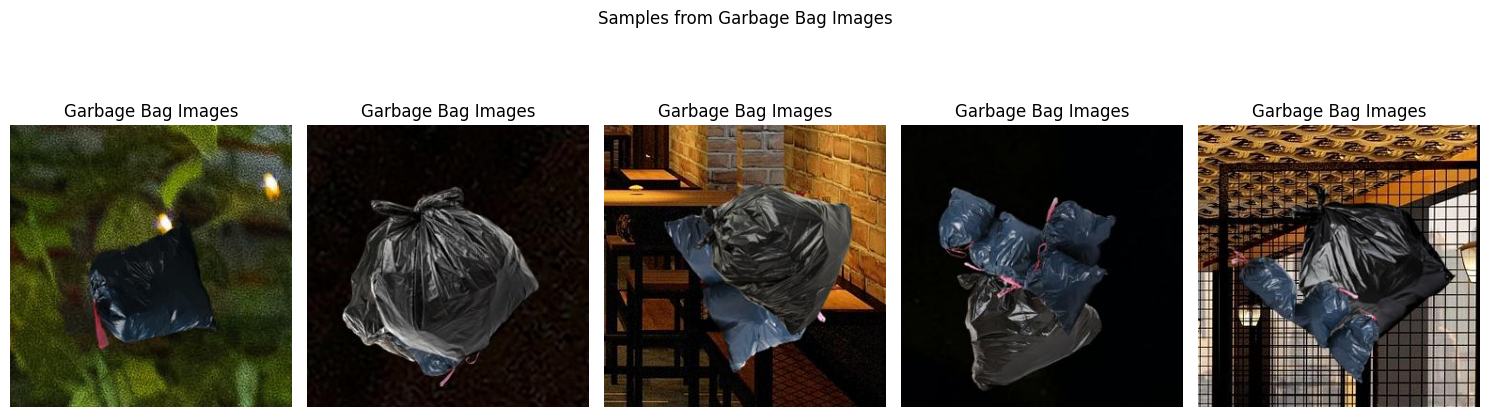

.data\Waste-Classification\Subsets\train\Paper Bag Images\Paper Bag Images(2075).jpg
.data\Waste-Classification\Subsets\train\Paper Bag Images\Paper Bag Images(1382).jpg
.data\Waste-Classification\Subsets\train\Paper Bag Images\Paper Bag Images(1107).jpg
.data\Waste-Classification\Subsets\train\Paper Bag Images\Paper Bag Images(1963).jpg
.data\Waste-Classification\Subsets\train\Paper Bag Images\Paper Bag Images(2402).jpg


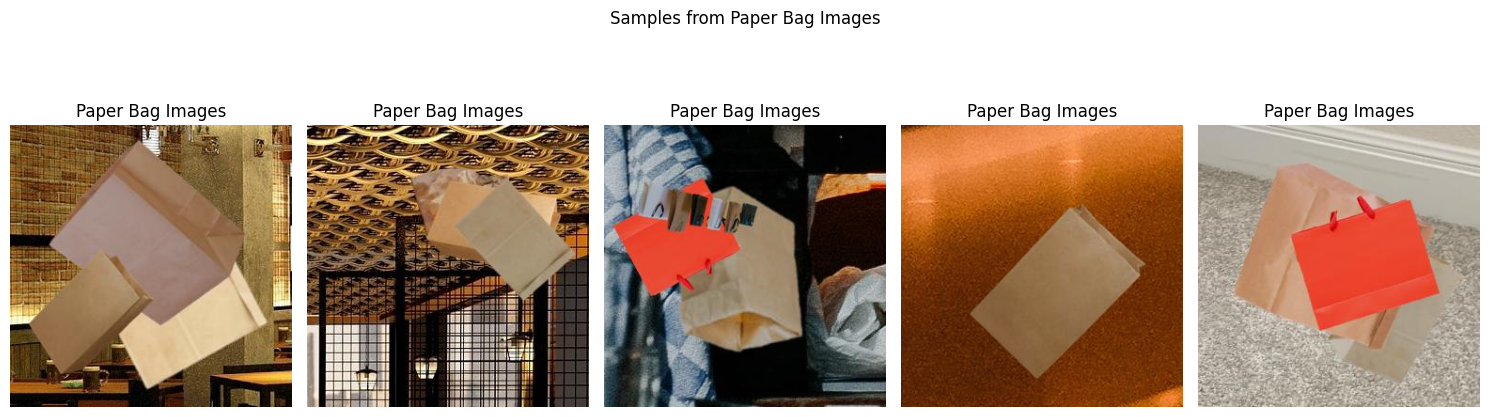

.data\Waste-Classification\Subsets\train\Plastic Bag Images\Plastic Bag Images(1430).jpg
.data\Waste-Classification\Subsets\train\Plastic Bag Images\Plastic Bag Images(2219).jpg
.data\Waste-Classification\Subsets\train\Plastic Bag Images\Plastic Bag Images(1313).jpg
.data\Waste-Classification\Subsets\train\Plastic Bag Images\Plastic Bag Images(2113).jpg
.data\Waste-Classification\Subsets\train\Plastic Bag Images\Plastic Bag Images(2399).jpg


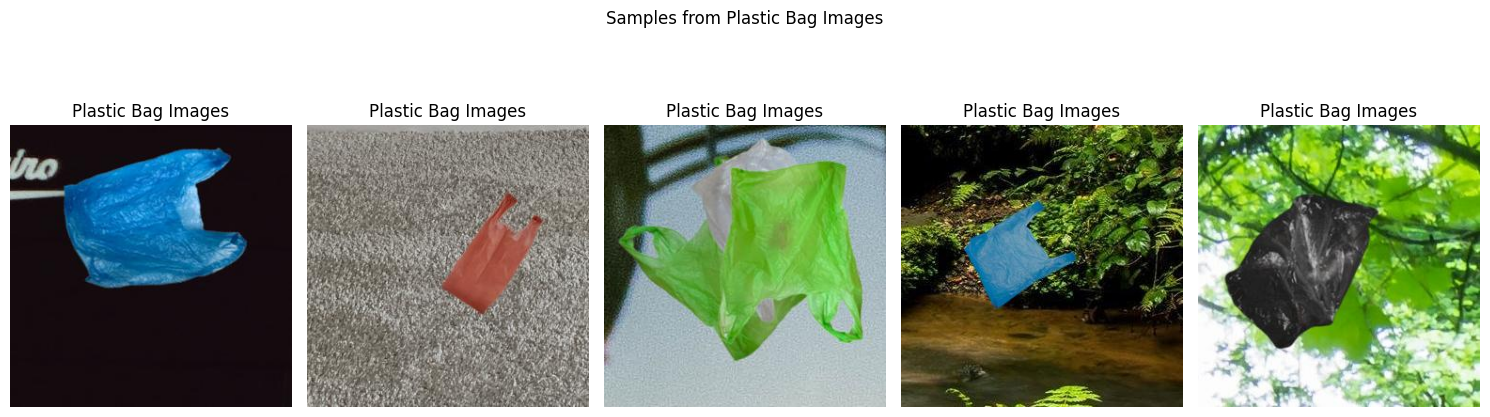

In [38]:
def display_sample_images(dataset_dir, num_samples=5):
    # Get all subdirectories (classes) in the dataset directory
    subdirs = [d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))]

    for label in subdirs:
        label_dir = os.path.join(dataset_dir, label)

        # Get all files in the current subdirectory
        files = [f for f in os.listdir(label_dir) if os.path.isfile(os.path.join(label_dir, f))]

        # Randomly select num_samples files
        random_files = random.sample(files, min(num_samples, len(files)))

        fig, axes = plt.subplots(1, len(random_files), figsize=(15, 5))
        fig.suptitle(f"Samples from {label}")

        for i, ax in enumerate(axes):
            img_path = os.path.join(label_dir, random_files[i])
            print(img_path)  # Print the image path for debugging
            img = Image.open(img_path)
            ax.imshow(img)
            ax.set_title(f"{label}")
            ax.axis('off')

        plt.tight_layout()
        plt.show()

# Call the function with your directory
display_sample_images(new_base_dir_train, 5)


#### Check average image size

In [39]:
def analyze_image_dimensions(base_dir, subset):
    dimensions = []
    for category in labels:
        dir_path = base_dir / subset / category
        for img_name in os.listdir(dir_path):
            img_path = dir_path / img_name
            with Image.open(img_path) as img:
                dimensions.append(img.size)
    
    dimensions = np.array(dimensions)
    print(f"Subset: {subset}")
    print(f"Mean Dimensions: {dimensions.mean(axis=0)}")
    print(f"Min Dimensions: {dimensions.min(axis=0)}")
    print(f"Max Dimensions: {dimensions.max(axis=0)}")

analyze_image_dimensions(new_base_dir, "train")

Subset: train
Mean Dimensions: [300. 300.]
Min Dimensions: [300 300]
Max Dimensions: [300 300]


#### Generate metadata for images

In [44]:
def generate_metadata(base_dir, subset):
    data = []
    for category in labels:
        dir_path = base_dir / subset / category
        for img_name in os.listdir(dir_path):
            img_path = dir_path / img_name
            with Image.open(img_path) as img:
                width, height = img.size
            data.append({
                "filename": img_name,
                "category": category,
                "subset": subset,
                "width": width,
                "height": height
            })
    return pd.DataFrame(data)

train_metadata = generate_metadata(new_base_dir, "train")
validation_metadata = generate_metadata(new_base_dir, "validation")
test_metadata = generate_metadata(new_base_dir, "test")


#### Visualize class distribution

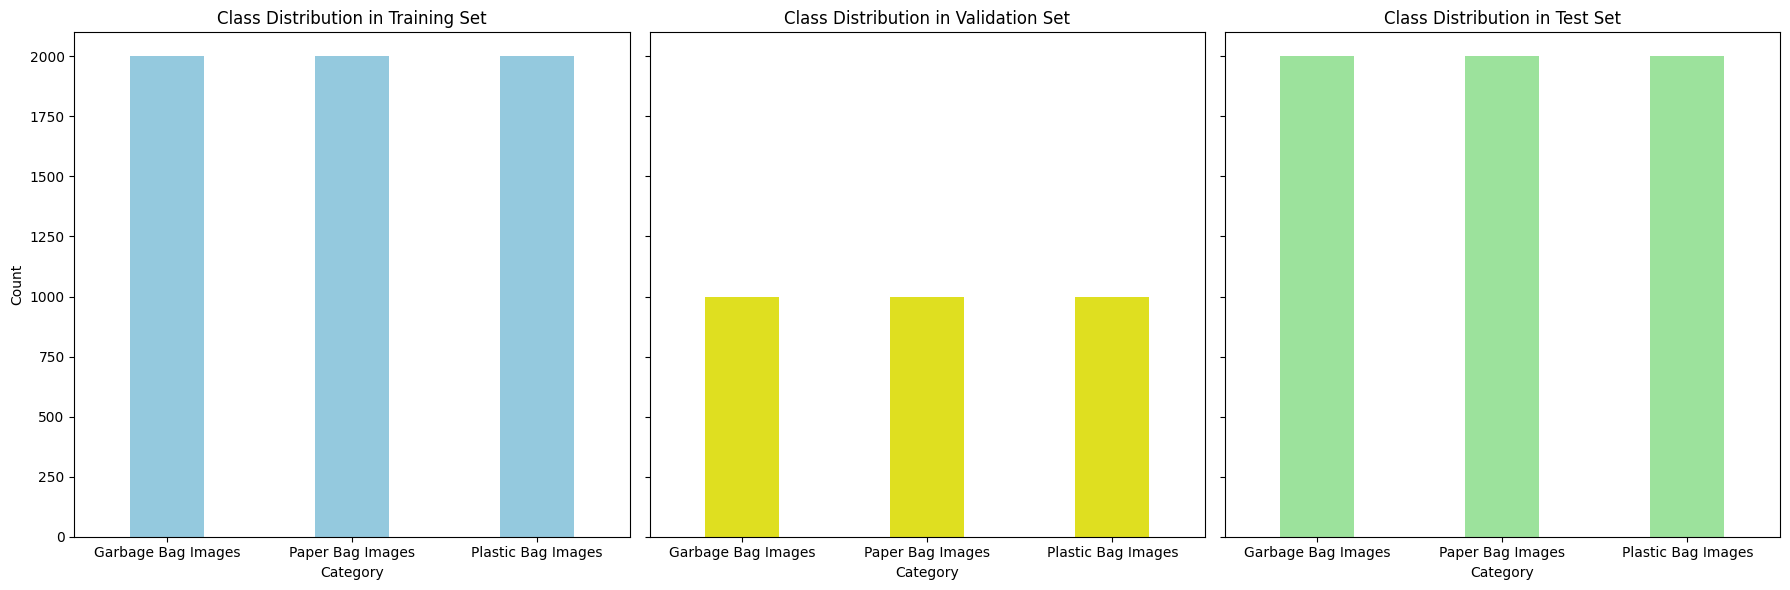

In [49]:
def plot_class_distributions(train_metadata, val_metadata, test_metadata):
    fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

    # Training set
    sns.countplot(data=train_metadata, x="category", ax=axes[0],color="skyblue",linewidth=0,width=0.4)
    axes[0].set_title("Class Distribution in Training Set")
    axes[0].set_xlabel("Category")
    axes[0].set_ylabel("Count")

    # Validation set
    sns.countplot(data=val_metadata, x="category", ax=axes[1],color="yellow",linewidth=0,width=0.4)
    axes[1].set_title("Class Distribution in Validation Set")
    axes[1].set_xlabel("Category")
    axes[1].set_ylabel("")  # Remove ylabel for aesthetics

    # Test set
    sns.countplot(data=test_metadata, x="category", ax=axes[2],color="lightgreen",linewidth=0,width=0.4)
    axes[2].set_title("Class Distribution in Test Set")
    axes[2].set_xlabel("Category")
    axes[2].set_ylabel("")  # Remove ylabel for aesthetics

    plt.tight_layout()
    plt.show()


# Example usage
plot_class_distributions(train_metadata, validation_metadata, test_metadata)

#### Visualize Image's dimensions Distribution in training set

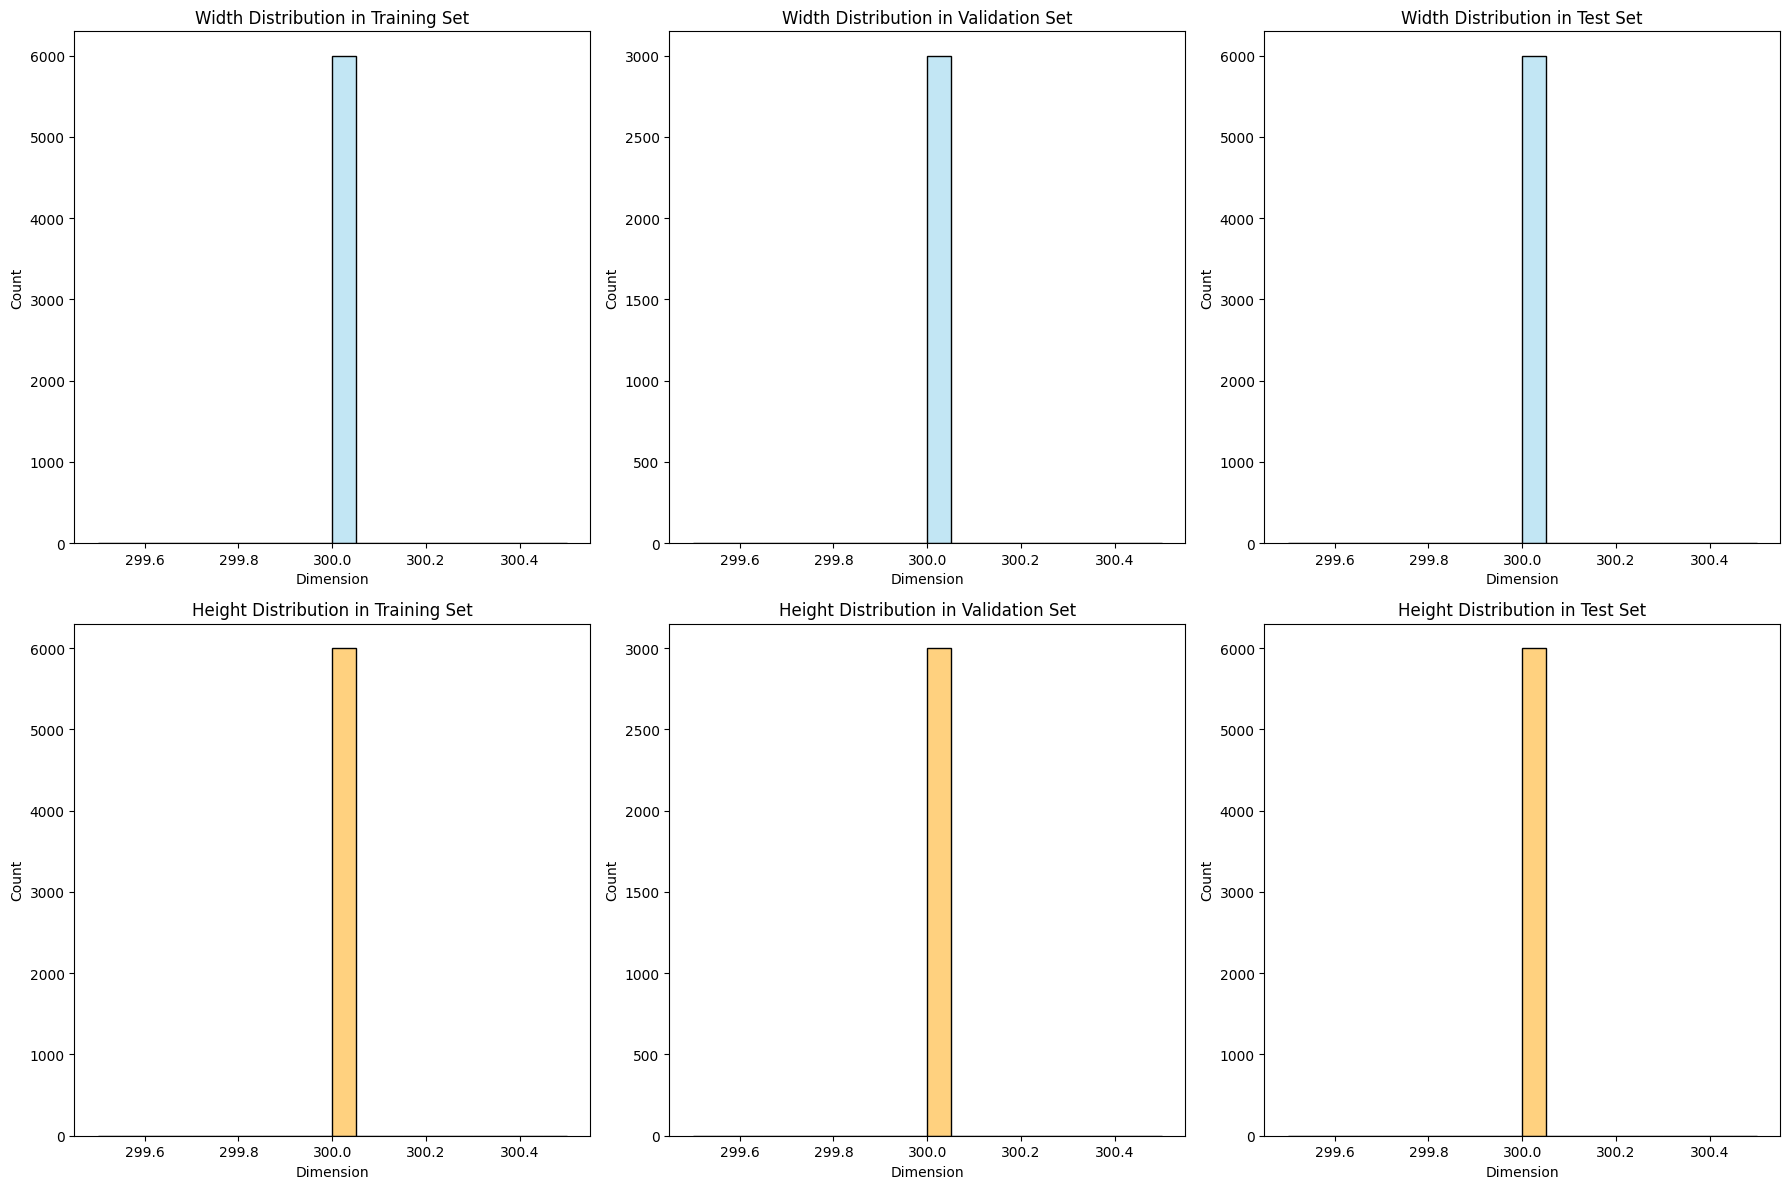

In [62]:
def plot_separate_dimension_distributions(train_metadata, val_metadata, test_metadata):
    fig, axes = plt.subplots(2, 3, figsize=(18, 12), sharey=False)

    # Width Distribution
    sns.histplot(data=train_metadata, x="width", bins=20, kde=True, ax=axes[0, 0], color="skyblue")
    axes[0, 0].set_title("Width Distribution in Training Set")
    sns.histplot(data=val_metadata, x="width", bins=20, kde=True, ax=axes[0, 1], color="skyblue")
    axes[0, 1].set_title("Width Distribution in Validation Set")
    sns.histplot(data=test_metadata, x="width", bins=20, kde=True, ax=axes[0, 2], color="skyblue")
    axes[0, 2].set_title("Width Distribution in Test Set")

    # Height Distribution
    sns.histplot(data=train_metadata, x="height", bins=20, kde=True, ax=axes[1, 0], color="orange")
    axes[1, 0].set_title("Height Distribution in Training Set")
    sns.histplot(data=val_metadata, x="height", bins=20, kde=True, ax=axes[1, 1], color="orange")
    axes[1, 1].set_title("Height Distribution in Validation Set")
    sns.histplot(data=test_metadata, x="height", bins=20, kde=True, ax=axes[1, 2], color="orange")
    axes[1, 2].set_title("Height Distribution in Test Set")

    for ax in axes.flat:
        ax.set_xlabel("Dimension")
        ax.set_ylabel("Count")

    plt.tight_layout()
    plt.show()

plot_separate_dimension_distributions(train_metadata, validation_metadata, test_metadata)


##### Create train, validation and test dataset using tansorflow

In [64]:
train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(300, 300),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(300, 300),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(300, 300),
    batch_size=32)

Found 6000 files belonging to 3 classes.
Found 3000 files belonging to 3 classes.
Found 6000 files belonging to 3 classes.


### Approach 1 : Convolutional Neural Network (CNN)

##### Model Definition

In [ ]:
inputs = keras.Input(shape=(300, 300, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.BatchNormalization()(x)  # BatchNormalization for stable training
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)  # Dropout to prevent overfitting
outputs = layers.Dense(1, activation="sigmoid")(x)  # For classification
model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 300, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_3 (Rescaling)         │ (None, 300, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 298, 298, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 149, 149, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 149, 149, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 147, 147, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 73, 73, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 73, 73, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 71, 71, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 35, 35, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 35, 35, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 33, 33, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 14, 14, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │       150,531 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,130,947 (4.31 MB)

 Trainable params: 1,129,987 (4.31 MB)

 Non-trainable params: 960 (3.75 KB)

##### Compile Model

In [70]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

##### Save anf fit model

In [71]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="./models/CNN_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]
CNN_history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 306s 2s/step - accuracy: 0.4691 - loss: 0.0000e+00 - val_accuracy: 0.3327 - val_loss: 0.0000e+00
Epoch 2/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 307s 2s/step - accuracy: 0.5459 - loss: 0.0000e+00 - val_accuracy: 0.3037 - val_loss: 0.0000e+00
Epoch 3/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 317s 2s/step - accuracy: 0.5648 - loss: 0.0000e+00 - val_accuracy: 0.5597 - val_loss: 0.0000e+00
Epoch 4/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 298s 2s/step - accuracy: 0.5493 - loss: 0.0000e+00 - val_accuracy: 0.5693 - val_loss: 0.0000e+00
Epoch 5/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 288s 2s/step - accuracy: 0.5304 - loss: 0.0000e+00 - val_accuracy: 0.6113 - val_loss: 0.0000e+00
Epoch 6/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 287s 2s/step - accuracy: 0.5205 - loss: 0.0000e+00 - val_accuracy: 0.5757 - val_loss: 0.0000e+00
Epoch 7/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 311s 2s/step - accuracy: 0.5063 - loss: 0.0000e+00 - val_accuracy: 0.3607 - val_loss: 0.0000e+00
Epoch 8/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 3

##### Review accuracy and training loss

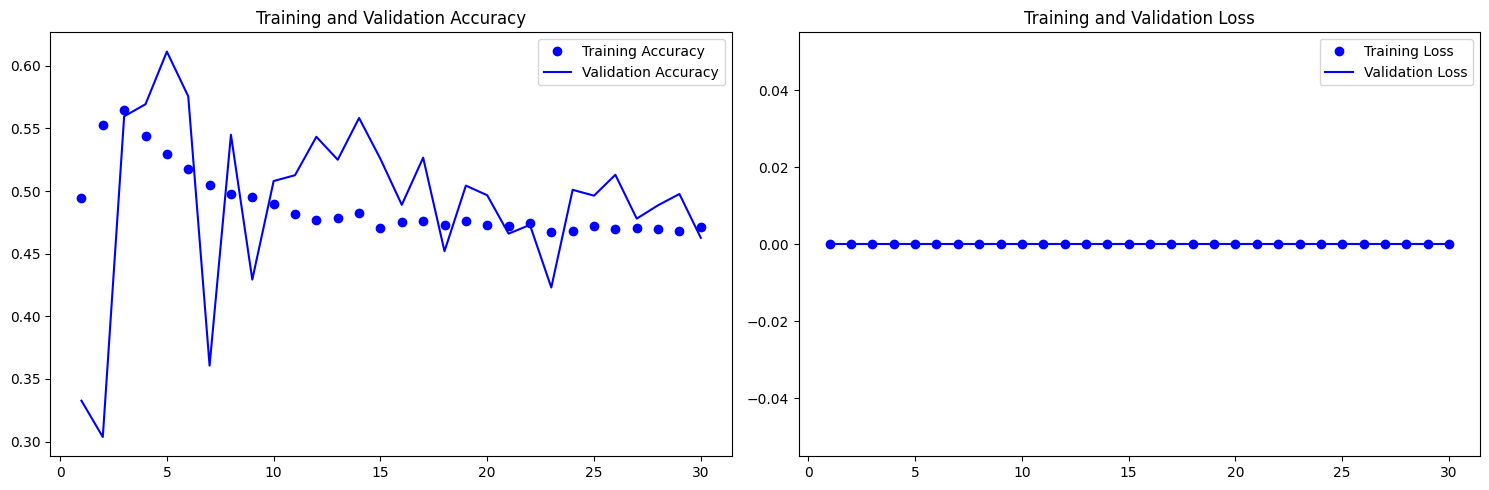

In [ ]:
cnn_accuracy = CNN_history.history["accuracy"]
cnn_val_accuracy = CNN_history.history["test_accuracy"]
cnn_loss = CNN_history.history["loss"]
cnn_val_loss = CNN_history.history["val_loss"]
cnn_epochs = range(1, len(cnn_accuracy) + 1)


# Create subplots with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot training and validation accuracy
axes[0].plot(cnn_epochs, cnn_accuracy, "bo", label="Training Accuracy")
axes[0].plot(cnn_epochs, cnn_val_accuracy, "b", label="Validation Accuracy")
axes[0].set_title("Training and Validation Accuracy")
axes[0].legend()

# Plot training and validation loss
axes[1].plot(cnn_epochs, cnn_loss, "bo", label="Training Loss")
axes[1].plot(cnn_epochs, cnn_val_loss, "b", label="Validation Loss")
axes[1].set_title("Training and Validation Loss")
axes[1].legend()

# Display the plots
plt.tight_layout()
plt.show()


##### Accuracy & Validation Loss for Train, Validation & Test

In [81]:
# Evaluate the model on the training dataset
train_loss, train_accuracy = model.evaluate(train_dataset, verbose=1)
print(f"Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")

# Evaluate the model on the validation dataset
val_loss, val_accuracy = model.evaluate(validation_dataset, verbose=1)
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_dataset, verbose=1)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


188/188 ━━━━━━━━━━━━━━━━━━━━ 62s 332ms/step - accuracy: 0.4691 - loss: 0.0000e+00
Training Loss: 0.0000, Training Accuracy: 0.4712
94/94 ━━━━━━━━━━━━━━━━━━━━ 33s 352ms/step - accuracy: 0.4555 - loss: 0.0000e+00
Validation Loss: 0.0000, Validation Accuracy: 0.4627
188/188 ━━━━━━━━━━━━━━━━━━━━ 71s 376ms/step - accuracy: 0.4735 - loss: 0.0000e+00
Test Loss: 0.0000, Test Accuracy: 0.4612


##### Best model accuracy

In [93]:
best_modell_cnn = keras.models.load_model("./models/CNN_from_scratch.keras")
test_loss, test_accuracy = best_modell_cnn.evaluate(x= test_dataset)
print(test_accuracy)

d:\Conestoga\CSCN8010-FAM\CSCN8010-labs\venvCSCN8010\Lib\site-packages\keras\src\losses\losses.py:27: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)


188/188 ━━━━━━━━━━━━━━━━━━━━ 69s 367ms/step - accuracy: 0.3323 - loss: 0.0000e+00
0.3331666588783264


##### Conclusion and next steps

- The results suggest the model is ***not learning effectively***. 
- The low and similar accuracy across the training, validation, and test datasets indicate ***potential issues*** such as ***inadequate model complexity, poor data quality, or improper processing***
- Updating model configurations in order to train model with different activation function and number of neurons in output layers

## Approach 2 : Training CNN with updated parameters

##### Model Defination and training

In [100]:
inputs = keras.Input(shape=(300, 300, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.BatchNormalization()(x)  # BatchNormalization for stable training
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)  # Dropout to prevent overfitting
outputs = layers.Dense(3, activation="softmax")(x)  # For classification
model_cnn_updated = keras.Model(inputs=inputs, outputs=outputs)
model_cnn_updated.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 300, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_6 (Rescaling)         │ (None, 300, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 298, 298, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 149, 149, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 149, 149, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 147, 147, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 73, 73, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 73, 73, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 71, 71, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 35, 35, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 35, 35, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 33, 33, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 14, 14, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 3)              │       150,531 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,130,947 (4.31 MB)

 Trainable params: 1,129,987 (4.31 MB)

 Non-trainable params: 960 (3.75 KB)

In [101]:
model_cnn_updated.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [102]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="./models/CNN_from_scratch_updated.keras",
        save_best_only=True,
        monitor="val_loss")
]
CNN_history_updated = model_cnn_updated.fit(
    train_dataset,
    epochs=20,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 312s 2s/step - accuracy: 0.6930 - loss: 3.7331 - val_accuracy: 0.4543 - val_loss: 11.2859
Epoch 2/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 334s 2s/step - accuracy: 0.8479 - loss: 2.4784 - val_accuracy: 0.6053 - val_loss: 4.7995
Epoch 3/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 324s 2s/step - accuracy: 0.9035 - loss: 0.9075 - val_accuracy: 0.7030 - val_loss: 2.1496
Epoch 4/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 313s 2s/step - accuracy: 0.9258 - loss: 0.4383 - val_accuracy: 0.8377 - val_loss: 0.4722
Epoch 5/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 313s 2s/step - accuracy: 0.9373 - loss: 0.2059 - val_accuracy: 0.9517 - val_loss: 0.1800
Epoch 6/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 314s 2s/step - accuracy: 0.9370 - loss: 0.1917 - val_accuracy: 0.9413 - val_loss: 0.1867
Epoch 7/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 305s 2s/step - accuracy: 0.9572 - loss: 0.1296 - val_accuracy: 0.9443 - val_loss: 0.1765
Epoch 8/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 389s 2s/step - accuracy: 0.9610 - loss: 0.1134 - val_acc

##### Review Accuracy & Training Loss

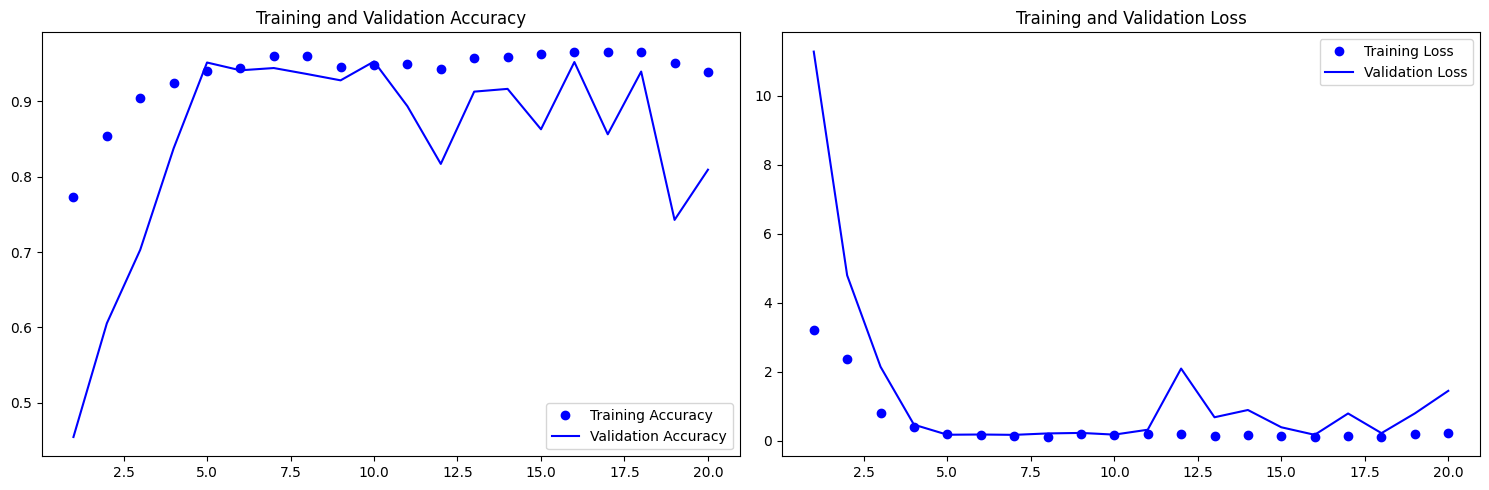

In [ ]:
cnn_updated_accuracy = CNN_history_updated.history["accuracy"]
cnn_updated_val_accuracy = CNN_history_updated.history["val_accuracy"]
cnn_updated_loss = CNN_history_updated.history["loss"]
cnn_updated_val_loss = CNN_history_updated.history["val_loss"]
cnn_updated_epochs = range(1, len(cnn_updated_accuracy) + 1)


# Create subplots with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot training and validation accuracy
axes[0].plot(cnn_updated_epochs, cnn_updated_accuracy, "bo", label="Training Accuracy")
axes[0].plot(cnn_updated_epochs, cnn_updated_val_accuracy, "b", label="Validation Accuracy")
axes[0].set_title("Training and Validation Accuracy")
axes[0].legend()

# Plot training and validation loss
axes[1].plot(cnn_updated_epochs, cnn_updated_loss, "bo", label="Training Loss")
axes[1].plot(cnn_updated_epochs, cnn_updated_val_loss, "b", label="Validation Loss")
axes[1].set_title("Training and Validation Loss")
axes[1].legend()

# Display the plots
plt.tight_layout()
plt.show()

In [ ]:
test_updated_cnn = keras.models.load_model("./models/CNN_from_scratch_updated.keras")
test_loss_updated , test_accuracy_updated = test_updated_cnn.evaluate(test_dataset)


188/188 ━━━━━━━━━━━━━━━━━━━━ 77s 405ms/step - accuracy: 0.9457 - loss: 0.1813
Test Accuracy: {test_accuracy_updated}


In [ ]:
print(f"Test Accuracy: {test_accuracy_updated}")

Test Accuracy: 0.9466666579246521


##### Accuracy & Validation Loss for Train, Validation & Test

In [109]:
# Evaluate the model on the training dataset
train_loss, train_accuracy = model_cnn_updated.evaluate(train_dataset, verbose=1)
print(f"Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")

# Evaluate the model on the validation dataset
val_loss, val_accuracy = model_cnn_updated.evaluate(validation_dataset, verbose=1)
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

# Evaluate the model on the test dataset
test_loss, test_accuracy = model_cnn_updated.evaluate(test_dataset, verbose=1)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

188/188 ━━━━━━━━━━━━━━━━━━━━ 77s 410ms/step - accuracy: 0.8069 - loss: 1.5023
Training Loss: 1.4291, Training Accuracy: 0.8145
94/94 ━━━━━━━━━━━━━━━━━━━━ 39s 418ms/step - accuracy: 0.8127 - loss: 1.4897
Validation Loss: 1.4525, Validation Accuracy: 0.8093
188/188 ━━━━━━━━━━━━━━━━━━━━ 83s 441ms/step - accuracy: 0.8014 - loss: 1.6074
Test Loss: 1.4925, Test Accuracy: 0.8050


##### CNN Predictions

In [110]:
cnn_pred_updated = (model_cnn_updated.predict(test_dataset) > 0.5).astype("int32")

188/188 ━━━━━━━━━━━━━━━━━━━━ 75s 399ms/step


##### Classification Report

In [111]:
from sklearn.metrics import classification_report

def get_predictions_and_labels(dataset, model):
    all_true_labels = []
    all_pred_labels = []

    for images, labels in dataset:
        # Predict class probabilities
        predictions = model_cnn_updated.predict(images)
        # Append true labels and predicted class indices
        all_true_labels.append(labels.numpy())
        all_pred_labels.append(np.argmax(predictions, axis=1))  # Convert probabilities to class indices

    return np.concatenate(all_true_labels), np.concatenate(all_pred_labels)

# Get true labels and predictions for train, validation, and test datasets
train_true_labels, train_pred_labels = get_predictions_and_labels(train_dataset, model_cnn_updated)
val_true_labels, val_pred_labels = get_predictions_and_labels(validation_dataset, model_cnn_updated)
test_true_labels, test_pred_labels = get_predictions_and_labels(test_dataset, model_cnn_updated)

# Generate classification reports
print("Classification Report for Training Dataset:")
print(classification_report(train_true_labels, train_pred_labels))

print("Classification Report for Validation Dataset:")
print(classification_report(val_true_labels, val_pred_labels))

print("Classification Report for Test Dataset:")
print(classification_report(test_true_labels, test_pred_labels))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

##### Confusion Matrix

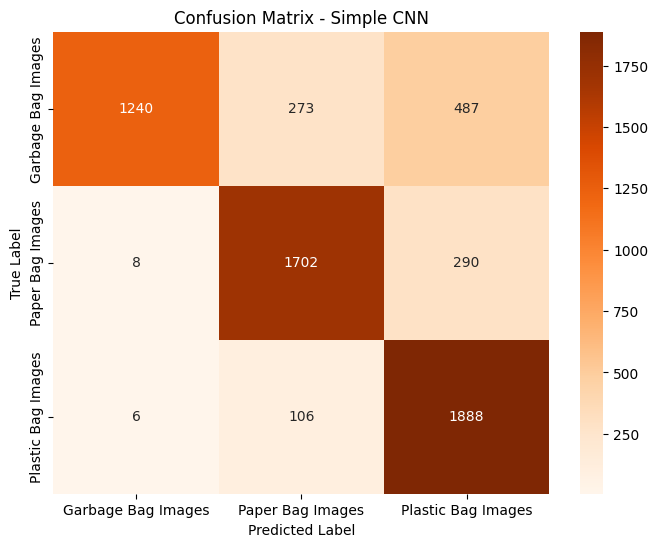

In [124]:
cm_cnn_updated = confusion_matrix(test_true_labels, test_pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_cnn_updated, annot=True, fmt='d', cmap='Oranges', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix - Simple CNN')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### Conclusion

The CNN model achieves around **81% accuracy** across training, validation, and test datasets, with balanced performance and no severe overfitting or underfitting. Class **0 (Garbage Bag)** shows high precision but lower recall, while Class **1 (Paper Bag)** has the most stable metrics, and Class **2 (Plastic Bag)** demonstrates high recall but lower precision. The confusion matrix indicates misclassifications between visually similar categories. To improve performance, consider data augmentation, hyperparameter tuning, or using pre-trained models for better feature extraction.

#### References

1. Cscn. (n.d.). GitHub - CSCN8010/CSCN8010: CSCN8010 Class notebooks. GitHub. https://github.com/CSCN8010/CSCN8010
2. Plastic - paper - garbage bag synthetic images. (2022, August 26). Kaggle. https://www.kaggle.com/datasets/vencerlanz09/plastic-paper-garbage-bag-synthetic-images/data